In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from torch.distributions import Normal

# Loading Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:

# Save the datasets
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

# Build NN (bias=0)

In [4]:
class CustomizableNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, use_bias):
        super(CustomizableNN, self).__init__()

        # Validate input
        assert num_layers == len(hidden_sizes), "Number of hidden layers should match the length of hidden_sizes."

        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0], bias=use_bias[0]), nn.Sigmoid()]

        # Hidden layers
        for i in range(1, num_layers):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i], bias=use_bias[i]), nn.Sigmoid()]

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size, bias=use_bias[-1]))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage:
input_size = 28 * 28
output_size = 10
# hidden_sizes = [512, 256, 128, 64]
hidden_sizes = [16,16]
num_layers = len(hidden_sizes)
use_bias =[0, 0, 0]


In [5]:
def reshape(original_list, rows=2, columns=16, add_size=10):
    reshaped_list = [original_list[i:i + columns] for i in range(0, rows * columns, columns)]
    add = original_list[-add_size:]
    reshaped_list.append(add)
    return reshaped_list



# Loss cross entropy

In [6]:
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Training the model
# num_epochs = 4  # Reduce the number of epochs for demonstration purposes
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         # Forward pass
#         outputs = model(inputs.view(-1, 28 * 28))
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Loss MSE

In [7]:
# Define Mean Squared Error (MSE) as the loss function
def loss_back(model, num_epochs, criterion = nn.MSELoss(), lr=0.001):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Training the model
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # Forward pass
            
            outputs = model(inputs.view(-1, 28 * 28))
            # Convert labels to one-hot encoding for MSE
            labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()

            # Compute MSE loss
            loss = criterion(outputs, labels_one_hot)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [8]:
# Create a customizable neural network
model = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias)
loss_back(model, num_epochs=4, criterion = nn.MSELoss(), lr=0.001)

Epoch [1/4], Loss: 0.0493
Epoch [2/4], Loss: 0.0184
Epoch [3/4], Loss: 0.0244
Epoch [4/4], Loss: 0.0193


# TEST

In [9]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.view(-1, 28 * 28))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 90.94%


# Estimated parameters

In [10]:
# Print the result weights and biases of each layer
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Weights: torch.Size([16, 784])
Layer: model.2.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.4.weight, Size: torch.Size([10, 16])
Weights: torch.Size([10, 16])


# Gradient loss of parameter

In [11]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    #print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.4.weight, Size: torch.Size([10, 16])


# Fisher Information

In [12]:
def fisher_diagonal(model,i):
    all_gradients_weight = [param.grad for name, param in model.named_parameters() if "weight" in name ]
    all_gradients_bias = [param.grad for name, param in model.named_parameters() if "bias" in name ]
    grad_vector_weight_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[1:-1]])
    grad_vector_weight_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_weight[-1][i]])
    grad_vector_weight = torch.cat([grad_vector_weight_hidden, grad_vector_weight_output],0)
    if len(all_gradients_bias) > 0:
        grad_vector_bias_hidden = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[:-1]])
        grad_vector_bias_output = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias[-1]])
        grad_vector_bias = torch.cat([grad_vector_bias_hidden, grad_vector_bias_output],0)
        grad_vector = torch.cat([grad_vector_weight,grad_vector_bias],0)
    else:
        grad_vector = grad_vector_weight
    grad_vector = grad_vector.view(-1, 1)
#         for param, gradient in zip(model.parameters(), all_gradients):
#             print(f"Gradient of loss w.r.t. {param[i]}:")
#             print(gradient)
#             print()
#         print('='*20)
#         print(grad_vector)
    G=torch.transpose(grad_vector,0,1)
    F=torch.matmul(grad_vector,G)
    return F,G,grad_vector

# Process the output and labels as probability.

In [13]:
def prob(outputs,labels):
    # re-probability outputs
    mini, _ = torch.min(outputs.data, 1)

    re_outputs = outputs-mini.view(-1, 1)
    re_outputs_p = re_outputs/torch.sum(re_outputs,1).view(-1, 1)
    
    # re-probability labels
    _, predicted = torch.max(outputs.data, 1)
    num_elements = labels.numel()
    identity_matrix = torch.eye(10)
    re_labels_p = nn.functional.one_hot(labels, num_classes=10).float()
#     re_labels_p = identity_matrix[labels] # set probability of labels
    return re_outputs_p, re_labels_p

# Confidence interval and Predictive interval

In [14]:
def confi_pred_interval(inputs, labels, model, a=0.050):
    """
    Function:
    - Calculate the confidence interval and predictive interval of results
    Input:
    - inout: The input of data
    - label: The label of handwriting input
    - model: The trained neural network
    - a: significant level
    Returns:
    - c: the size of confidence interval
    - c_p: the list of confidence interval for each kinds label {0,1,...,9}
    - mu: the estimate output
    - y_p: the list of predictive interval for each kinds label {0,1,...,9}
    """
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
#     loss = (torch.sum((re_outputs_p-re_labels_p)**2,1)/2)
    loss = (torch.mean((re_outputs_p-re_labels_p),dim=0)**2)
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = (torch.sum((re_outputs_p-y_p)**2,1)/2)
    
    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H=torch.pinverse(F) #use the pseudo-inverse 
        w=torch.mm(G,H)
        w=torch.mm(w,grad_vector)
        
        
        # CI
        sigma_epsilon_squared = 1/4*loss[i]
#         sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
        print(f"interva size:{ci}")
        print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [15]:
# for inputs, labels in test_loader:
    
#     c, c_p, mu, y_p= confi_pred_interval(inputs, labels, model, a=0.025)
#     break

# Building NN (bias=unknown)

In [16]:
model_adj = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True] )

In [17]:
loss_back(model_adj, num_epochs=5, criterion = nn.MSELoss(), lr=0.001)

Epoch [1/5], Loss: 0.0380
Epoch [2/5], Loss: 0.0260
Epoch [3/5], Loss: 0.0177
Epoch [4/5], Loss: 0.0121
Epoch [5/5], Loss: 0.0214


In [18]:
# Print the result weights and biases of each layer
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data.size()}')
    elif 'bias' in name:
        print(f'Biases: {param.data.size()}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Weights: torch.Size([16, 784])
Layer: model.0.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.2.weight, Size: torch.Size([16, 16])
Weights: torch.Size([16, 16])
Layer: model.2.bias, Size: torch.Size([16])
Biases: torch.Size([16])
Layer: model.4.weight, Size: torch.Size([10, 16])
Weights: torch.Size([10, 16])
Layer: model.4.bias, Size: torch.Size([10])
Biases: torch.Size([10])


In [19]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
#     print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.0.bias, Size: torch.Size([16])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.2.bias, Size: torch.Size([16])
Layer: model.4.weight, Size: torch.Size([10, 16])
Layer: model.4.bias, Size: torch.Size([10])


# Numerical way to calculate $\frac{\partial s}{\partial \alpha}$

In [20]:
def numerical_derivative(model,NN, bias, j,epsilon):
    """
    Function:
    -Numerically approximate the derivative of a function f at point x using finite differences.
    Input:
    - model:the Neural network model
    - bias: The bias list for 
    - i: The index of target output
    - j: The index of target bias to derivative
    Returns:
    - derivative for parameter y[i]
    """
    derivative = torch.tensor([])
    bias_plus_epsilon = bias
    bias_minus_epsilon = bias
    bias_plus_epsilon[j] = bias[j] + epsilon
    bias_minus_epsilon[j] = bias[j] - epsilon
    bias_plus = reshape(bias_plus_epsilon)
    bias_minus = reshape(bias_minus_epsilon)
    model_up = NN(input_size, output_size, hidden_sizes, num_layers, bias_plus)
    model_down = NN(input_size, output_size, hidden_sizes, num_layers, bias_minus)
    print("backforward up")
    loss_back(model_up, num_epochs=2, lr=0.001)
    print("backforward down")
    loss_back(model_down, num_epochs=2, lr=0.001)
    
    for i in range(10):
        all_gradients_bias_up = [param.grad for name, param in model_up.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[1:-1]])
        grad_vector_bias_output_up = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_up[-1][i]])
        grad_vector_bias_up = torch.cat([grad_vector_bias_hidden_up, grad_vector_bias_output_up],0)
        grad_vector_bias_up = grad_vector_bias_up.view(-1, 1)
        
        all_gradients_bias_down = [param.grad for name, param in model_down.named_parameters() if "weight" in name ]
        grad_vector_bias_hidden_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[1:-1]])
        grad_vector_bias_output_down = torch.cat([g.contiguous().view(-1) for g in all_gradients_bias_down[-1][i]])
        grad_vector_bias_down = torch.cat([grad_vector_bias_hidden_down, grad_vector_bias_output_down],0)
        grad_vector_bias_down = grad_vector_bias_down.view(-1, 1)
        
        each_derivative = (grad_vector_bias_up-grad_vector_bias_down)/ 2 * epsilon
        derivative = torch.cat([derivative, each_derivative.unsqueeze(0)], 0)
    
    return derivative
    

In [21]:
def derivative_whole(use_bias, epsilon=1e-6):
    dS_da_whole = torch.tensor([])
    for j in range(len(use_bias)):
        detrivate = numerical_derivative(model,CustomizableNN, deepcopy(use_bias), j,epsilon)
        dS_da_whole = torch.cat([dS_da_whole, detrivate], -1)
    return dS_da_whole

In [22]:
# dS_da_whole=derivative_whole(use_bias=[0 for _ in range(1*16+1*10)])

In [23]:
# torch.save(dS_da_whole, 'dS_da_whole_tensor_layers2.pt')
loaded_tensor_layers2 = torch.load('dS_da_whole_tensor_layers2.pt')
dS_da_whole = loaded_tensor_layers2

In [24]:
dS_da_whole

tensor([[[-4.4707e-10, -1.0159e-09,  2.9048e-10,  ..., -7.2849e-11,
          -6.2559e-10, -1.1043e-10],
         [-4.9221e-10, -1.5334e-09,  1.3576e-10,  ...,  5.9721e-10,
          -5.2145e-10, -2.2594e-10],
         [-2.9515e-11, -1.6926e-09,  2.7332e-10,  ...,  4.4237e-10,
          -2.3318e-10, -1.5103e-10],
         ...,
         [-1.6128e-09,  2.9867e-09,  3.8498e-09,  ...,  8.1310e-10,
          -1.4358e-09, -2.1619e-09],
         [-2.7957e-09,  3.5709e-09,  4.4398e-09,  ...,  4.8223e-10,
           6.0635e-11, -1.3365e-09],
         [-1.8505e-09,  1.9557e-09,  3.8809e-09,  ...,  1.2936e-09,
          -3.5658e-10, -8.0842e-10]],

        [[-4.4707e-10, -1.0159e-09,  2.9048e-10,  ..., -7.2849e-11,
          -6.2559e-10, -1.1043e-10],
         [-4.9221e-10, -1.5334e-09,  1.3576e-10,  ...,  5.9721e-10,
          -5.2145e-10, -2.2594e-10],
         [-2.9515e-11, -1.6926e-09,  2.7332e-10,  ...,  4.4237e-10,
          -2.3318e-10, -1.5103e-10],
         ...,
         [-1.1584e-09,  1

# Estimate Var($\alpha$):
estimate bias for each batch, and use Bayesian way to estimate variance of each bias parameter

In [25]:
# Store estimated bias terms for each batch
model_va = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias = [True,True,True,True,True] )
estimated_bias_per_batch = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model_va.parameters(), lr=0.001)  
# Training loop
i=0
for inputs, labels in train_loader:
    i+=1
    # Training the model
    # Zero the gradients
    optimizer.zero_grad()
    for epoch in range(5):
            outputs = model_va(inputs.view(-1, 28 * 28))
            labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()
            loss = criterion(outputs, labels_one_hot)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    estimated_bias_per_layer = [param.detach().numpy() for name, param in model_va.named_parameters() if 'bias' in name]
    estimated_bias_per_layer =np.concatenate(estimated_bias_per_layer).tolist()
    estimated_bias_per_batch.append(estimated_bias_per_layer)



In [26]:

import numpy as np
datasets=[]
for i in range(len(estimated_bias_per_batch[1])):
    data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
    datasets.append(data_list)
covariance_matrix = np.cov(datasets)

print("Covariance Matrix:")
print(covariance_matrix)
V=covariance_matrix
         
# def Adjust(model_adj,num_layers,dS_da_whole_epoch1,V):
#     Adj = torch.tensor([])
#     for i in range(10):
#         F, G, grad_vector = fisher_diagonal(model_adj,i)
#         F_in= torch.pinverse(F)
#         r = len(F)
#         l = sum(hidden_sizes)+10
#         n = len(train_loader)
# #         Va = torch.diag(V, diagonal=0)
# #         Va = torch.diag(torch.tensor([1] * l), diagonal=0)

#         Va = torch.tensor(V, dtype=torch.float32)
#         Vo = F_in[0:r-l,0:r-l]
#         print(Vo)
#         dS_da = dS_da_whole[i,:,:]
#         D = torch.mm(Vo,dS_da)
#         D_t = torch.transpose(D,0,1)
#         if D.dtype != Va.dtype:
#             Va = Va.to(D.dtype)
#         A = torch.mm(D,Va)
#         A = torch.mm(A,D_t)
#         Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
#     return Adj

Covariance Matrix:
[[ 1.08708637e-04  9.37687203e-05 -9.56118988e-05 ... -1.23690935e-04
  -4.42746653e-05  1.66966197e-04]
 [ 9.37687203e-05  1.12627305e-04 -1.00117765e-04 ... -1.24564499e-04
  -7.45801484e-05  1.92904851e-04]
 [-9.56118988e-05 -1.00117765e-04  1.07221273e-04 ...  1.28161783e-04
   7.20266742e-05 -1.97617797e-04]
 ...
 [-1.23690935e-04 -1.24564499e-04  1.28161783e-04 ...  1.67379833e-04
   8.32770983e-05 -2.50942927e-04]
 [-4.42746653e-05 -7.45801484e-05  7.20266742e-05 ...  8.32770983e-05
   1.17045465e-04 -1.90715303e-04]
 [ 1.66966197e-04  1.92904851e-04 -1.97617797e-04 ... -2.50942927e-04
  -1.90715303e-04  4.67081047e-04]]


In [27]:
def variance(data):
    # Define the Bayesian linear regression model
    class BayesianLinearRegression(nn.Module):
        def __init__(self):
            super(BayesianLinearRegression, self).__init__()
            self.mean_weight = nn.Parameter(torch.randn(1))
            self.log_variance_weight = nn.Parameter(torch.randn(1))

        def forward(self, x):
            mean = x * self.mean_weight
            variance = torch.exp(self.log_variance_weight)
            return Normal(mean, variance.sqrt())

    # Instantiate the model and set up optimization
    model_B = BayesianLinearRegression()
    optimizer = optim.Adam(model_B.parameters(), lr=0.01)

    # Training loop for Bayesian inference
    num_epochs = 1000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        likelihood = model_B(data)
        loss = -likelihood.log_prob(data).sum()  # Negative log likelihood as loss
        loss.backward()
        optimizer.step()

    # Get the estimated variance from the model
    estimated_variance = torch.exp(model_B.log_variance_weight).item()
    return estimated_variance

In [28]:
V = []
for i in range(len(estimated_bias_per_batch[1])):
    data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
    data = torch.tensor(data_list, dtype=torch.float32)
    var = variance(data)
    V.append(var)
V = torch.tensor(V)   

# Adjustment term

In [29]:
def Adjust(model_adj,num_layers,dS_da_whole_epoch1,V):
    Adj = torch.tensor([])
    for i in range(10):
        F, G, grad_vector = fisher_diagonal(model_adj,i)
        F_in= torch.pinverse(F)
        r = len(F)
        l = sum(hidden_sizes)+10
        n = len(train_loader)
#         Va = torch.diag(V, diagonal=0)
        Va = torch.diag(torch.tensor([1] * l), diagonal=0)
        
        Vo = F_in[0:r-l,0:r-l]
        dS_da = dS_da_whole[i,:,:]
        D = torch.mm(Vo,dS_da)
        D_t = torch.transpose(D,0,1)
        if D.dtype != Va.dtype:
            Va = Va.to(D.dtype)
        A = torch.mm(D,Va)
        A = torch.mm(A,D_t)
        Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
    return Adj

In [30]:
Adj= Adjust(model_adj,num_layers,dS_da_whole,V)

In [31]:
def adj_confi_pred_interval(inputs, labels, model,Adj, a=0.05):
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
#     loss = (torch.sum((re_outputs_p-re_labels_p)**2,1)/2)
    loss = (torch.mean((re_outputs_p-re_labels_p),dim=0)**2)
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = (torch.sum((re_outputs_p-y_p)**2,1)/2)
    
    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H = torch.pinverse(F) #use the pseudo-inverse 
        H = H + Adj[i]
        w = torch.mm(G,H)
        w = torch.mm(w,grad_vector)

        # CI
        sigma_epsilon_squared = 1/4*loss[i]
#         sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        print(ci)
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
#         print(f"interva size:{ci}")
#         print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [37]:
import torch

# Initialize empty lists to accumulate data
X_list = []
y_list = []
i=0
# Iterate over the batches in the test_loader
for inputs, labels in test_loader:
    i+=1
    # Append the batch data to the lists
    X_list.append(inputs)
    y_list.append(labels)
    if i==50:
        break
# Concatenate the lists to create a single dataset pair
X = torch.cat(X_list, dim=0)
y = torch.cat(y_list, dim=0)

adj_c, adj_c_p, mu, y_p= adj_confi_pred_interval(X, y, model, Adj, a=0.05)
c, c_p, mu, y_p= confi_pred_interval(X, y, model, a=0.05)


number:0
tensor([[0.0076]], grad_fn=<MulBackward0>)
number:1
tensor([[0.0093]], grad_fn=<MulBackward0>)
number:2
tensor([[0.0438]], grad_fn=<MulBackward0>)
number:3
tensor([[0.0241]], grad_fn=<MulBackward0>)
number:4
tensor([[0.0099]], grad_fn=<MulBackward0>)
number:5
tensor([[0.0157]], grad_fn=<MulBackward0>)
number:6
tensor([[0.0071]], grad_fn=<MulBackward0>)
number:7
tensor([[0.0010]], grad_fn=<MulBackward0>)
number:8
tensor([[0.0037]], grad_fn=<MulBackward0>)
number:9
tensor([[0.0318]], grad_fn=<MulBackward0>)
number:0
interva size:tensor([[0.0071]], grad_fn=<MulBackward0>)
p interva size:0.01505244616419077
number:1
interva size:tensor([[0.0052]], grad_fn=<MulBackward0>)
p interva size:0.009634888730943203
number:2
interva size:tensor([[0.0219]], grad_fn=<MulBackward0>)
p interva size:0.017507338896393776
number:3
interva size:tensor([[0.0067]], grad_fn=<MulBackward0>)
p interva size:0.016659028828144073
number:4
interva size:tensor([[0.0072]], grad_fn=<MulBackward0>)
p interva si

In [38]:
# for inputs, labels in test_loader:
#     adj_c, adj_c_p, mu, y_p= adj_confi_pred_interval(inputs, labels, model, Adj, a=0.025)
#     c, c_p, mu, y_p= confi_pred_interval(inputs, labels, model, a=0.025)
#     break

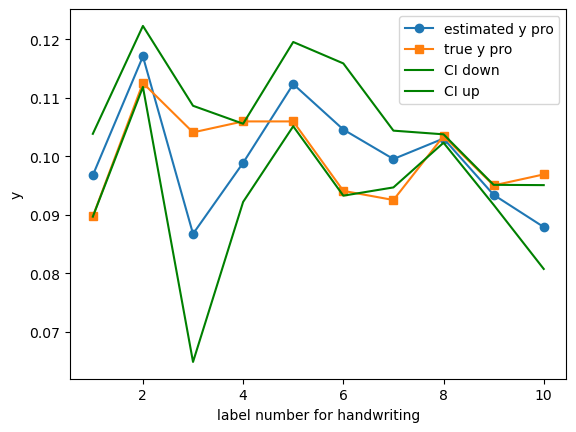

In [39]:
x_np = range(1, 11)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_np[0,:,0], '-', label='CI down', color='green')
plt.plot(x_np, c_np[0,:,1], '-', label='CI up',color='green')
# plt.plot(x_np, c_p_np[0,:,0], '-', label='CI_p down', color='red')
# plt.plot(x_np, c_p_np[0,:,1], '-', label='CI_p up', color='red')
plt.xlabel('label number for handwriting')
plt.ylabel('y')
plt.legend()

plt.show()


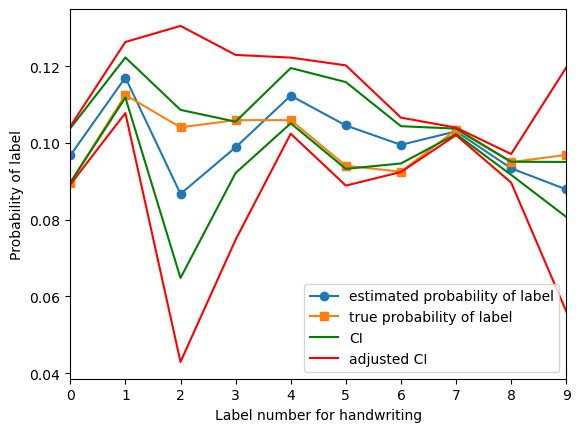

In [42]:
x_np = range(0, 10)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
adj_c_np = adj_c.detach().numpy()
adj_c_p_np = adj_c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated probability of label')
plt.plot(x_np, y_np, 's-', label='true probability of label')
plt.plot(x_np, c_np[0,:,0], '-', label='CI', color='green')
plt.plot(x_np, c_np[0,:,1], '-',color='green')
plt.plot(x_np, adj_c_np[0,:,0], '-', label='adjusted CI', color='red')
plt.plot(x_np, adj_c_np[0,:,1], '-',color='red')
plt.xlim(0, 9)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Label number for handwriting')
plt.ylabel('Probability of label')
plt.legend()
plt.savefig('MNIST NN layer2222.jpg', format='jpg')
plt.show()


In [43]:
# import torch

# # # Save the results to a file
# # torch.save({'adj_c': adj_c, 'adj_c_p': adj_c_p, 'mu': mu, 'y_p': y_p,
# #             'c': c, 'c_p': c_p, 'mu': mu, 'y_p': y_p}, 'confidence_intervals_MINIST_layers2.pth')

# # Load the data back into your program
# loaded_data = torch.load('confidence_intervals_MINIST_layers2.pth')

# # Access the saved variables
# loaded_adj_c = loaded_data['adj_c']
# loaded_adj_c_p = loaded_data['adj_c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']
# loaded_c = loaded_data['c']
# loaded_c_p = loaded_data['c_p']
# loaded_mu = loaded_data['mu']
# loaded_y_p = loaded_data['y_p']


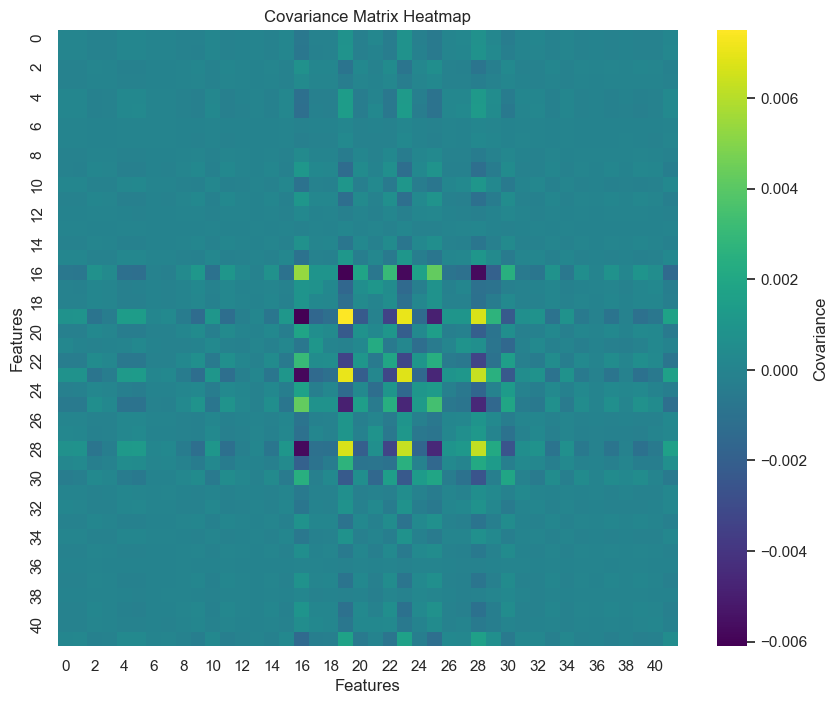

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
vv = deepcopy(covariance_matrix)
def replace_diagonal(matrix, replacement_values):
    if len(replacement_values) != len(matrix):
        raise ValueError("Number of replacement values must match the size of the diagonal.")

    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if i == j:  # Check if the current element is on the diagonal
                matrix[i][j] = replacement_values[i]
                
replace_diagonal(vv, V)  

sns.set(style='white')
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, cmap='viridis', cbar_kws={'label': 'Covariance'}, annot=False)

# Set plot labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Covariance Matrix Heatmap')

# Show the plot
plt.show()

In [45]:
covariance_matrix

array([[ 1.08708637e-04,  9.37687203e-05, -9.56118988e-05, ...,
        -1.23690935e-04, -4.42746653e-05,  1.66966197e-04],
       [ 9.37687203e-05,  1.12627305e-04, -1.00117765e-04, ...,
        -1.24564499e-04, -7.45801484e-05,  1.92904851e-04],
       [-9.56118988e-05, -1.00117765e-04,  1.07221273e-04, ...,
         1.28161783e-04,  7.20266742e-05, -1.97617797e-04],
       ...,
       [-1.23690935e-04, -1.24564499e-04,  1.28161783e-04, ...,
         1.67379833e-04,  8.32770983e-05, -2.50942927e-04],
       [-4.42746653e-05, -7.45801484e-05,  7.20266742e-05, ...,
         8.32770983e-05,  1.17045465e-04, -1.90715303e-04],
       [ 1.66966197e-04,  1.92904851e-04, -1.97617797e-04, ...,
        -2.50942927e-04, -1.90715303e-04,  4.67081047e-04]])

In [46]:
# Print the result weights and biases of each layer
for name, param in model_adj.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'model.4.weight' in name:
        p=param

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.0.bias, Size: torch.Size([16])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.2.bias, Size: torch.Size([16])
Layer: model.4.weight, Size: torch.Size([10, 16])
Layer: model.4.bias, Size: torch.Size([10])


In [47]:
pp=p[3][-3:-1].detach().numpy()

In [48]:
F, G, grad_vector = fisher_diagonal(model,3)
f = F[-3:-1,-3:-1]
f

tensor([[3.0165e-07, 2.9359e-08],
        [2.9359e-08, 2.8575e-09]])

In [49]:
H=torch.inverse(f)
h = H/len( y)
h

tensor([[ 3.0997e+10, -3.1847e+11],
        [-3.1847e+11,  3.2721e+12]])

In [50]:
adj = Adj[3][-3:-1,-3:-1]
adj

tensor([[2977.8389, -769.1240],
        [-769.1240, 6124.8569]])

In [51]:
cov_matrix = h.numpy()
a = adj.numpy()
cov_matrix2 =cov_matrix + a

[[3.303086e+12]
 [1.243987e+03]]
[[3.303086e+12]
 [3.272768e+03]]


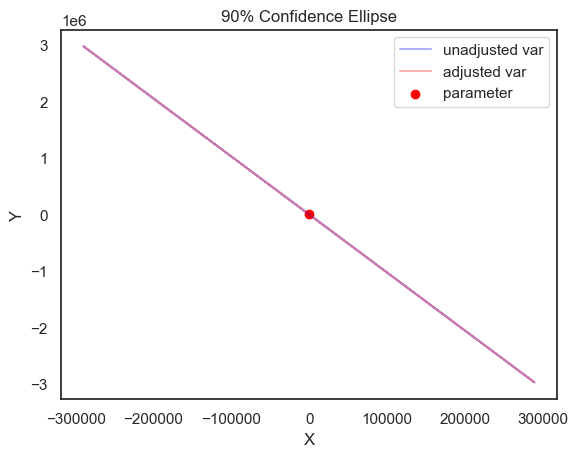

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def plot_confidence_ellipse(covariance_matrix, ax, n_std=2, **kwargs):
    """
    Plot a confidence ellipse for a 2D distribution based on its covariance matrix.

    Parameters:
    - covariance_matrix: Covariance matrix of the distribution.
    - ax: Matplotlib axes on which to plot the ellipse.
    - n_std: Number of standard deviations for the ellipse. Default is 2 (95% confidence).
    - **kwargs: Additional keyword arguments to pass to the ellipse patch.

    Returns:
    - ellipse: Ellipse artist.
    """
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Create a 2D grid of points on the unit circle
    theta = np.linspace(0, 2 * np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])
    print(eigenvalues.reshape(-1, 1))
    # Scale and rotate the unit circle to create the ellipse
    ellipse = n_std * np.sqrt(eigenvalues.reshape(-1, 1)) * unit_circle
    transformation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                                      [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    ellipse = np.dot(transformation_matrix, ellipse)

    # Extract the mean of the distribution
    mean = pp  # Change this if your distribution is not centered at the origin

    # Plot the ellipse
    ellipse = ax.plot(ellipse[0, :] + mean[0], ellipse[1, :] + mean[1], **kwargs)
    return ellipse


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix, ax, n_std=1.645, color='blue', alpha=0.3, label='unadjusted var')
# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix2, ax, n_std=1.645, color='red', alpha=0.3, label='adjusted var')
plt.scatter(pp[0], pp[1], color='red', label='parameter')
# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('90% Confidence Ellipse')
plt.legend()
# Show the plot
plt.show()


[[3.303086e+12]
 [1.243987e+03]]
[[3.303086e+12]
 [3.272768e+03]]


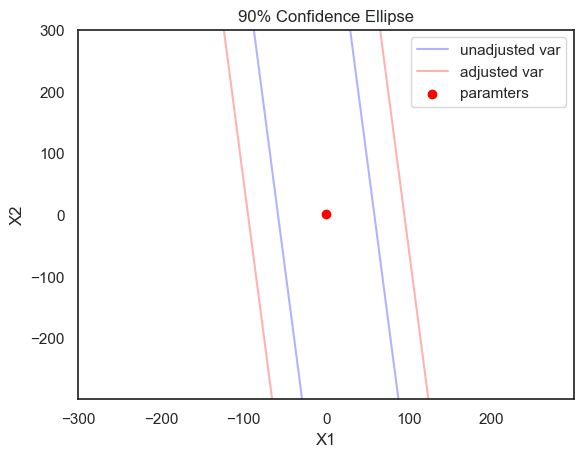

In [53]:

# Create a figure and axes
fig, ax = plt.subplots()
# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix, ax, n_std=1.645, color='blue', alpha=0.3, label='unadjusted var')
# Plot the confidence ellipse with 90% confidence (1.645 standard deviations)
plot_confidence_ellipse(cov_matrix2, ax, n_std=1.645, color='red', alpha=0.3, label='adjusted var')
plt.scatter(pp[0], pp[1], color='red', label='paramters')
# Set axis labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('90% Confidence Ellipse')
plt.xlim(pp[0]-300, pp[0]+300)  # Set x-axis range from -5 to 5
plt.ylim(pp[1]-300, pp[1]+300) 
# Show the plot
plt.legend()
plt.savefig('MNIST lay2 part.jpg', format='jpg')
plt.show()


In [54]:
import numpy as np
from scipy.stats import pearsonr

# Example data matrix
data_matrix = np.array([
    [1, 2, 3, 4, 5],
    [2, 4, 5, 4, 5],
    [3, 1, 2, 3, 4],
    [4, 3, 4, 2, 3],
])

# Get the number of parameters (columns)
num_parameters = data_matrix.shape[0]

# Create a matrix to store correlation coefficients
correlation_matrix = np.zeros((num_parameters, num_parameters))

# Calculate Pearson correlation coefficient for each pair of parameters
for i in range(num_parameters):
    for j in range(num_parameters):
        correlation_matrix[i, j], _ = pearsonr(data_matrix[i], data_matrix[j])

# Print the correlation matrix
print("Pearson Correlation Coefficient Matrix:")
print(correlation_matrix)


Pearson Correlation Coefficient Matrix:
[[ 1.00000000e+00  7.74596669e-01  5.54700196e-01 -5.66946710e-01]
 [ 7.74596669e-01  1.00000000e+00  1.91320330e-17 -2.43975018e-01]
 [ 5.54700196e-01  1.91320330e-17  1.00000000e+00 -1.57242726e-01]
 [-5.66946710e-01 -2.43975018e-01 -1.57242726e-01  1.00000000e+00]]


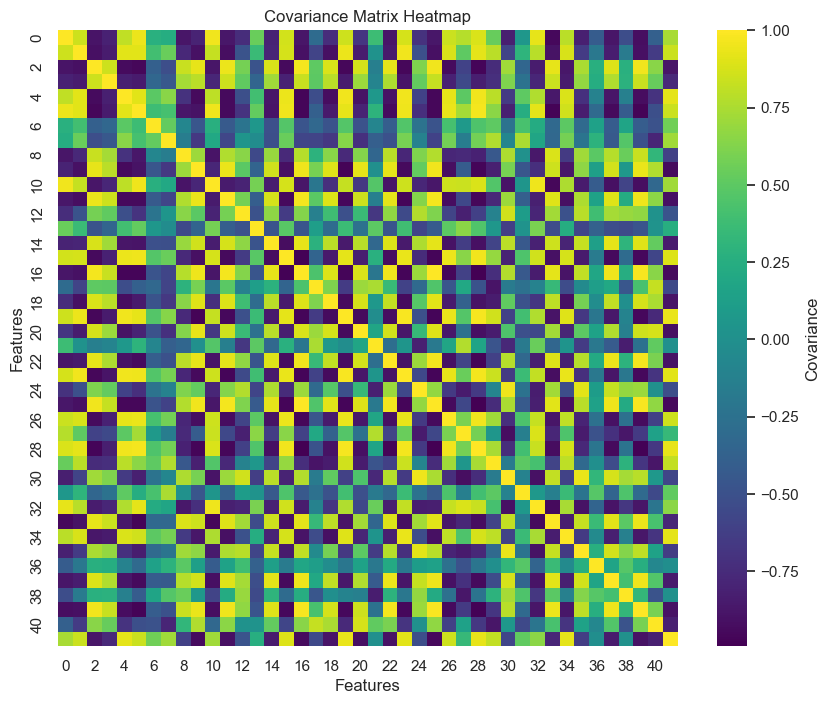

In [55]:
import numpy as np
datasets=[]
for i in range(len(estimated_bias_per_batch[1])):
    data_list = [per_batch[i] for per_batch in estimated_bias_per_batch]
    datasets.append(data_list)
from scipy.stats import pearsonr


# Get the number of parameters (lists)
num_parameters = len(datasets)

# Create a matrix to store correlation coefficients
correlation_matrix = [[0 for _ in range(num_parameters)] for _ in range(num_parameters)]

# Calculate Pearson correlation coefficient for each pair of parameters
for i in range(num_parameters):
    for j in range(num_parameters):
        correlation_matrix[i][j], _ = pearsonr(datasets[i], datasets[j])


sns.set(style='white')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', cbar_kws={'label': 'Covariance'}, annot=False)

# Set plot labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Covariance Matrix Heatmap')

# Show the plot
plt.show()
